In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
import sklearn.preprocessing as pr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


In [2]:
def create_gridcvs():
    #Initializing Classifiers
    clf1 = LogisticRegression(max_iter = 5000)
    clf2 = KNeighborsClassifier()
    clf3 = tree.DecisionTreeClassifier()

    #Building the pipelines
    pipe1 = Pipeline([('std', StandardScaler()),
                      ('classifier', clf1)])

    pipe2 = Pipeline([('std', StandardScaler()),
                      ('classifier', clf2)])

    pipe3 = Pipeline([('std', StandardScaler()),
                      ('classifier', clf3)])

    #Setting up the parameter grids
    param_grid1 = [{'classifier__penalty': ['l1','l2'],
                   'classifier__C': np.power(10., np.arange(-8, 4))}]

    param_grid2 = [{'classifier__n_neighbors': [int(x) for x in np.logspace(0,2.7,num=25)]}]

    param_grid3 = [{'classifier__max_depth': [x for x in range(1,26)]}]

    # Setting up multiple GridSearchCV objects, 1 for each algorithm
    gridcvs = {}

    for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3),
                               (pipe1, pipe2, pipe3),
                               ('Logistic', 'KNN', 'DecisionTree')):
        gcv = GridSearchCV(estimator=est,
                          param_grid = pgrid,
                          scoring = 'accuracy',
                          n_jobs = 4,
                          cv = 5,
                          verbose = 0,
                          refit = True)
        gridcvs[name] = gcv

    return gridcvs

## Dataset 4 (Connect-4)

In [3]:
connect4 = pd.read_csv('connect-4.data')
connect4

,b,b.1,b.2,b.3,b.4,b.5,b.6,b.7,b.8,b.9,...,b.25,b.26,b.27,b.28,b.29,b.30,b.31,b.32,b.33,win
0,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
1,b,b,b,b,b,b,o,b,b,b,...,b,b,b,b,b,b,b,b,b,win
2,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
3,o,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
4,b,b,b,b,b,b,b,b,b,b,...,b,b,b,o,b,b,b,b,b,win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67551,x,x,b,b,b,b,o,x,o,b,...,b,b,b,o,o,x,b,b,b,loss
67552,x,x,b,b,b,b,o,b,b,b,...,b,b,b,o,x,o,o,x,b,draw
67553,x,x,b,b,b,b,o,o,b,b,...,b,b,b,o,x,x,o,b,b,loss
67554,x,o,b,b,b,b,o,b,b,b,...,b,b,b,o,x,o,x,x,b,draw


In [4]:
le = LabelEncoder()

for col in connect4:
    connect4[col] = le.fit_transform(connect4[col])

connect4.head()

X = connect4.drop(['win'], axis = 1)
Y = connect4['win']

print(X.shape)
print(Y.shape)

(67556, 42)
(67556,)


In [5]:
scores = {}
scores['Logistic'] = []
scores['KNN'] = []
scores['DecisionTree'] = []

## Trial 1

In [6]:
gridcvs = create_gridcvs()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size = 5000,
                                                   random_state = 1234)

scaler = pr.MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(5000, 42)
(5000,)
(62556, 42)
(62556,)


In [8]:
%%time

cv_scores = {name: [] for name, gs_est in gridcvs.items()}

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

c = 1
for outer_train_idx, outer_valid_idx in skfold.split(X_train,y_train):
    for name, gs_est in sorted(gridcvs.items()):
        print('outer fold %d/5 | tuning %-8s' % (c, name), end='')

        # The inner loop for hyperparameter tuning
        gs_est.fit(X_train[outer_train_idx], y_train[outer_train_idx])
        y_pred = gs_est.predict(X_train[outer_valid_idx])
        acc = accuracy_score(y_true=y_train[outer_valid_idx], y_pred=y_pred)
        print(' | inner ACC %.2f%% | outer ACC %.2f%%' %
              (gs_est.best_score_ * 100, acc * 100))
        cv_scores[name].append(acc)

    c += 1

outer fold 1/5 | tuning DecisionTree | inner ACC 65.88% | outer ACC 66.90%
outer fold 1/5 | tuning KNN      | inner ACC 66.10% | outer ACC 66.90%
outer fold 1/5 | tuning Logistic | inner ACC 64.83% | outer ACC 64.90%
outer fold 2/5 | tuning DecisionTree | inner ACC 66.55% | outer ACC 65.80%
outer fold 2/5 | tuning KNN      | inner ACC 66.65% | outer ACC 65.60%
outer fold 2/5 | tuning Logistic | inner ACC 64.90% | outer ACC 64.80%
outer fold 3/5 | tuning DecisionTree | inner ACC 65.97% | outer ACC 66.20%
outer fold 3/5 | tuning KNN      | inner ACC 66.25% | outer ACC 64.90%
outer fold 3/5 | tuning Logistic | inner ACC 64.85% | outer ACC 64.80%
outer fold 4/5 | tuning DecisionTree | inner ACC 66.33% | outer ACC 67.50%
outer fold 4/5 | tuning KNN      | inner ACC 65.55% | outer ACC 65.00%
outer fold 4/5 | tuning Logistic | inner ACC 64.85% | outer ACC 64.80%
outer fold 5/5 | tuning DecisionTree | inner ACC 65.90% | outer ACC 64.10%
outer fold 5/5 | tuning KNN      | inner ACC 66.75% | out

In [9]:
for name in cv_scores:
    print('%-8s | outer CV acc. %.2f%% +\- %.3f' % (
          name, 100 * np.mean(cv_scores[name]), 100 * np.std(cv_scores[name])))
print()
for name in cv_scores:
    print('{} best parameters'.format(name), gridcvs[name].best_params_)

Logistic | outer CV acc. 64.82% +\- 0.040
KNN      | outer CV acc. 65.58% +\- 0.714
DecisionTree | outer CV acc. 66.10% +\- 1.158

Logistic best parameters {'classifier__C': 1e-08, 'classifier__penalty': 'l2'}
KNN best parameters {'classifier__n_neighbors': 17}
DecisionTree best parameters {'classifier__max_depth': 2}


In [10]:
## get the respective test and training set errors for all algorithms 
##trial 1
trial1_err = {}
for name in gridcvs:
    clf = gridcvs[name].best_estimator_
    clf.fit(X_train, y_train)
    print('Optimal Training Performance for {}: {:.2f}%'.format(name, clf.score(X_train, y_train)*100))
    print('Optimal Test Performance for {}: {:.2f}%'.format(name, clf.score(X_test, y_test)*100))
    print()
    trial1_err[name] = np.array((clf.score(X_train, y_train), clf.score(X_test, y_test)))
    scores[name].append(clf.score(X_test, y_test))
    
trial1_err

Optimal Training Performance for Logistic: 64.84%
Optimal Test Performance for Logistic: 65.91%

Optimal Training Performance for KNN: 70.96%
Optimal Test Performance for KNN: 67.50%

Optimal Training Performance for DecisionTree: 65.54%
Optimal Test Performance for DecisionTree: 65.91%



{'Logistic': array([0.6484    , 0.65908946]),
 'KNN': array([0.7096    , 0.67501119]),
 'DecisionTree': array([0.6554    , 0.65908946])}

## Trial 2

In [11]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, 
                                                    train_size = 5000,
                                                   random_state = 123)

scaler = pr.MinMaxScaler()

X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)
y_train2 = y_train2.to_numpy()
y_test2 = y_test2.to_numpy()

print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(5000, 42)
(5000,)
(62556, 42)
(62556,)


In [12]:
%%time

cv_scores = {name: [] for name, gs_est in gridcvs.items()}

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

c = 1
for outer_train_idx, outer_valid_idx in skfold.split(X_train2,y_train2):
    for name, gs_est in sorted(gridcvs.items()):
        print('outer fold %d/5 | tuning %-8s' % (c, name), end='')

        # The inner loop for hyperparameter tuning
        gs_est.fit(X_train2[outer_train_idx], y_train2[outer_train_idx])
        y_pred = gs_est.predict(X_train2[outer_valid_idx])
        acc = accuracy_score(y_true=y_train2[outer_valid_idx], y_pred=y_pred)
        print(' | inner ACC %.2f%% | outer ACC %.2f%%' %
              (gs_est.best_score_ * 100, acc * 100))
        cv_scores[name].append(acc)

    c += 1

outer fold 1/5 | tuning DecisionTree | inner ACC 67.85% | outer ACC 70.60%
outer fold 1/5 | tuning KNN      | inner ACC 67.10% | outer ACC 67.00%
outer fold 1/5 | tuning Logistic | inner ACC 66.03% | outer ACC 66.10%
outer fold 2/5 | tuning DecisionTree | inner ACC 66.55% | outer ACC 68.20%
outer fold 2/5 | tuning KNN      | inner ACC 66.88% | outer ACC 66.80%
outer fold 2/5 | tuning Logistic | inner ACC 66.18% | outer ACC 66.00%
outer fold 3/5 | tuning DecisionTree | inner ACC 67.30% | outer ACC 67.30%
outer fold 3/5 | tuning KNN      | inner ACC 66.95% | outer ACC 66.80%
outer fold 3/5 | tuning Logistic | inner ACC 66.20% | outer ACC 65.40%
outer fold 4/5 | tuning DecisionTree | inner ACC 67.30% | outer ACC 64.00%
outer fold 4/5 | tuning KNN      | inner ACC 67.52% | outer ACC 66.90%
outer fold 4/5 | tuning Logistic | inner ACC 66.07% | outer ACC 65.90%
outer fold 5/5 | tuning DecisionTree | inner ACC 67.07% | outer ACC 66.90%
outer fold 5/5 | tuning KNN      | inner ACC 67.10% | out

In [13]:
for name in cv_scores:
    print('%-8s | outer CV acc. %.2f%% +\- %.3f' % (
          name, 100 * np.mean(cv_scores[name]), 100 * np.std(cv_scores[name])))
print()
for name in cv_scores:
    print('{} best parameters'.format(name), gridcvs[name].best_params_)

Logistic | outer CV acc. 65.88% +\- 0.248
KNN      | outer CV acc. 66.84% +\- 0.102
DecisionTree | outer CV acc. 67.40% +\- 2.131

Logistic best parameters {'classifier__C': 0.001, 'classifier__penalty': 'l2'}
KNN best parameters {'classifier__n_neighbors': 13}
DecisionTree best parameters {'classifier__max_depth': 7}


In [14]:
trial2_err = {}
for name in gridcvs:
    clf = gridcvs[name].best_estimator_
    clf.fit(X_train2, y_train2)
    print('Optimal Training Performance for {}: {:.2f}%'.format(name, clf.score(X_train2, y_train2)*100))
    print('Optimal Test Performance for {}: {:.2f}%'.format(name, clf.score(X_test2, y_test2)*100))
    print()
    trial2_err[name] = np.array((clf.score(X_train2, y_train2), clf.score(X_test2, y_test2)))
    scores[name].append(clf.score(X_test2, y_test2))
    
trial2_err

Optimal Training Performance for Logistic: 66.14%
Optimal Test Performance for Logistic: 65.73%

Optimal Training Performance for KNN: 71.90%
Optimal Test Performance for KNN: 67.27%

Optimal Training Performance for DecisionTree: 72.58%
Optimal Test Performance for DecisionTree: 67.28%



{'Logistic': array([0.6614    , 0.65731505]),
 'KNN': array([0.719     , 0.67270925]),
 'DecisionTree': array([0.7258    , 0.67278918])}

## Trial 3

In [15]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, Y, 
                                                    train_size = 5000/X.shape[0],
                                                   random_state = 12)

scaler = pr.MinMaxScaler()

X_train3 = scaler.fit_transform(X_train3)
X_test3 = scaler.transform(X_test3)
y_train3 = y_train3.to_numpy()
y_test3 = y_test3.to_numpy()

print(X_train3.shape)
print(y_train3.shape)
print(X_test3.shape)
print(y_test3.shape)

(5000, 42)
(5000,)
(62556, 42)
(62556,)


In [16]:
%%time

cv_scores = {name: [] for name, gs_est in gridcvs.items()}

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

c = 1
for outer_train_idx, outer_valid_idx in skfold.split(X_train3,y_train3):
    for name, gs_est in sorted(gridcvs.items()):
        print('outer fold %d/5 | tuning %-8s' % (c, name), end='')

        # The inner loop for hyperparameter tuning
        gs_est.fit(X_train3[outer_train_idx], y_train3[outer_train_idx])
        y_pred = gs_est.predict(X_train3[outer_valid_idx])
        acc = accuracy_score(y_true=y_train3[outer_valid_idx], y_pred=y_pred)
        print(' | inner ACC %.2f%% | outer ACC %.2f%%' %
              (gs_est.best_score_ * 100, acc * 100))
        cv_scores[name].append(acc)

    c += 1

outer fold 1/5 | tuning DecisionTree | inner ACC 67.38% | outer ACC 66.00%
outer fold 1/5 | tuning KNN      | inner ACC 66.60% | outer ACC 66.00%
outer fold 1/5 | tuning Logistic | inner ACC 66.18% | outer ACC 66.20%
outer fold 2/5 | tuning DecisionTree | inner ACC 68.65% | outer ACC 67.50%
outer fold 2/5 | tuning KNN      | inner ACC 66.82% | outer ACC 66.40%
outer fold 2/5 | tuning Logistic | inner ACC 66.10% | outer ACC 66.20%
outer fold 3/5 | tuning DecisionTree | inner ACC 67.67% | outer ACC 65.70%
outer fold 3/5 | tuning KNN      | inner ACC 67.55% | outer ACC 65.10%
outer fold 3/5 | tuning Logistic | inner ACC 66.38% | outer ACC 66.60%
outer fold 4/5 | tuning DecisionTree | inner ACC 67.35% | outer ACC 70.00%
outer fold 4/5 | tuning KNN      | inner ACC 66.42% | outer ACC 66.70%
outer fold 4/5 | tuning Logistic | inner ACC 66.05% | outer ACC 66.00%
outer fold 5/5 | tuning DecisionTree | inner ACC 67.32% | outer ACC 68.50%
outer fold 5/5 | tuning KNN      | inner ACC 66.80% | out

In [17]:
for name in cv_scores:
    print('%-8s | outer CV acc. %.2f%% +\- %.3f' % (
          name, 100 * np.mean(cv_scores[name]), 100 * np.std(cv_scores[name])))
print()
for name in cv_scores:
    print('{} best parameters'.format(name), gridcvs[name].best_params_)

Logistic | outer CV acc. 66.30% +\- 0.219
KNN      | outer CV acc. 66.20% +\- 0.616
DecisionTree | outer CV acc. 67.54% +\- 1.596

Logistic best parameters {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
KNN best parameters {'classifier__n_neighbors': 22}
DecisionTree best parameters {'classifier__max_depth': 5}


In [18]:
trial3_err = {}
for name in gridcvs:
    clf = gridcvs[name].best_estimator_
    clf.fit(X_train3, y_train3)
    print('Optimal Training Performance for {}: {:.2f}%'.format(name, clf.score(X_train3, y_train3)*100))
    print('Optimal Test Performance for {}: {:.2f}%'.format(name, clf.score(X_test3, y_test3)*100))
    print()
    trial3_err[name] = np.array((clf.score(X_train3, y_train3), clf.score(X_test3, y_test3)))
    scores[name].append(clf.score(X_test3, y_test3))
    
trial3_err
          

Optimal Training Performance for Logistic: 66.52%
Optimal Test Performance for Logistic: 65.99%

Optimal Training Performance for KNN: 69.06%
Optimal Test Performance for KNN: 67.36%

Optimal Training Performance for DecisionTree: 68.72%
Optimal Test Performance for DecisionTree: 66.96%



{'Logistic': array([0.6652    , 0.65987275]),
 'KNN': array([0.6906    , 0.67362044]),
 'DecisionTree': array([0.6872    , 0.66959205])}

## Results

In [19]:
print(trial1_err)
print(trial2_err)
print(trial3_err)


{'Logistic': array([0.6484    , 0.65908946]), 'KNN': array([0.7096    , 0.67501119]), 'DecisionTree': array([0.6554    , 0.65908946])}
{'Logistic': array([0.6614    , 0.65731505]), 'KNN': array([0.719     , 0.67270925]), 'DecisionTree': array([0.7258    , 0.67278918])}
{'Logistic': array([0.6652    , 0.65987275]), 'KNN': array([0.6906    , 0.67362044]), 'DecisionTree': array([0.6872    , 0.66959205])}


In [20]:
avg_trial_err = {}
for name in trial1_err:
    avg_trial_err[name] = np.array((trial1_err[name] + 
                          trial2_err[name] +
                          trial3_err[name])/3.)

for name in avg_trial_err:
    print("Mean training set performance for Letters dataset for {} algorithm: {:.5f}%".format(name, avg_trial_err[name][0]*100))
    print("Mean test set performance for Letters dataset for {} algorithm: {:.5f}%".format(name, avg_trial_err[name][1]*100))
    print()

Mean training set performance for Letters dataset for Logistic algorithm: 65.83333%
Mean test set performance for Letters dataset for Logistic algorithm: 65.87591%

Mean training set performance for Letters dataset for KNN algorithm: 70.64000%
Mean test set performance for Letters dataset for KNN algorithm: 67.37803%

Mean training set performance for Letters dataset for DecisionTree algorithm: 68.94667%
Mean test set performance for Letters dataset for DecisionTree algorithm: 66.71569%



In [21]:
avg_trial = pd.DataFrame.from_dict(avg_trial_err)
avg_trial['Set'] = ['Train', 'Test']
avg_trial = avg_trial.reindex(columns = ['Set', 'Logistic', 'KNN', 'DecisionTree'])
avg_trial

,Set,Logistic,KNN,DecisionTree
0,Train,0.658333,0.70640,0.689467
1,Test,0.658759,0.67378,0.667157


In [22]:
avg_trial.to_csv(r'Connect4_Machine_Learning.csv', index = False, header = True)

In [23]:
connect4_scores = pd.DataFrame.from_dict(scores)
connect4_scores = connect4_scores.reindex(columns = ['Logistic','KNN','DecisionTree'])
connect4_scores

,Logistic,KNN,DecisionTree
0,0.659089,0.675011,0.659089
1,0.657315,0.672709,0.672789
2,0.659873,0.673620,0.669592


In [24]:
connect4_scores.to_csv(r'connect4_scores.csv', index = False, header = True)

## Visualization

### Heatmaps

In [25]:
import seaborn as sns

In [34]:
# Draw heatmaps for result of grid search.
def draw_heatmap(errors, D_list, ylabel, name, title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(errors, annot=False, fmt='.3f', yticklabels=D_list, xticklabels=[])
    ax.collections[0].colorbar.set_label('error')
    ax.set(ylabel= ylabel)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(title)
    plt.savefig('{}.jpg'.format(name))
    plt.show()

In [35]:
d_list = [x for x in range(26)]
n_list = [int(x) for x in np.logspace(0,2.7,num=25)]
l_list = np.power(10., np.arange(-8, 4))

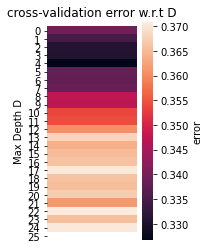

In [36]:
error = 1 - gridcvs['DecisionTree'].cv_results_['mean_test_score']
cross_val_score = np.reshape(error, (len(error), 1))
draw_heatmap(cross_val_score, d_list, "Max Depth D", 'DecisionTree Heatmap CONNECT4 Dataset', title='cross-validation error w.r.t D')



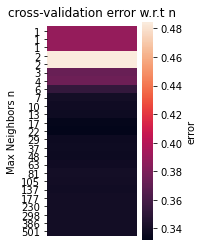

In [29]:
error = 1 - gridcvs['KNN'].cv_results_['mean_test_score']
cross_val_score = np.reshape(error, (len(error), 1))
draw_heatmap(cross_val_score, n_list, "Max Neighbors n", 'KNN Heatmap CONNECT4 Dataset', title='cross-validation error w.r.t n')

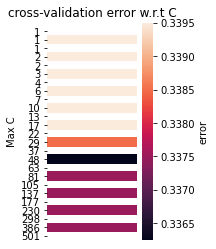

In [30]:
error = 1 - gridcvs['Logistic'].cv_results_['mean_test_score']
cross_val_score = np.reshape(error, (len(error), 1))
draw_heatmap(cross_val_score, n_list, "Max C", 'Logistic Heatmap CONNECT4 Dataset', title='cross-validation error w.r.t C')

### Learning Curves

In [31]:
from sklearn.model_selection import learning_curve

In [32]:
def plot(train_sizes, train_scores, test_scores, name):
    # Creating means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    # Creating means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Drawing lines
    plt.subplots(1, figsize=(10,10))
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")
    
    # Drawing bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
    
    # Creating plot
    plt.title("Learning Curve for {}". format(name))
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.savefig('{}.jpg'.format(name))
    plt.show()

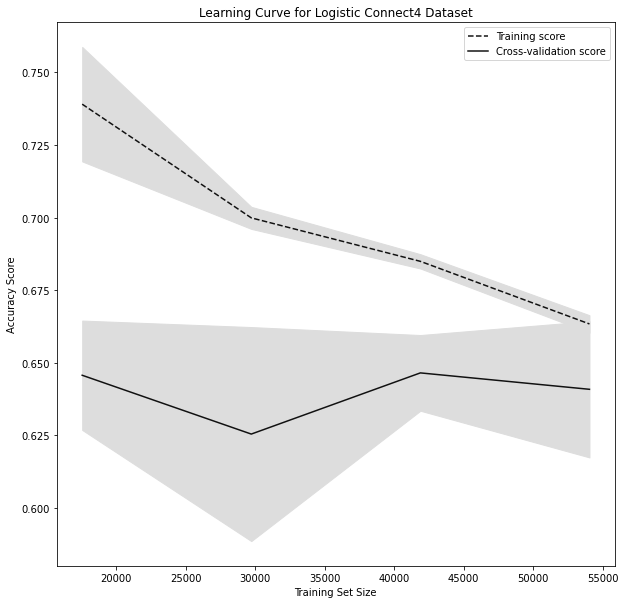

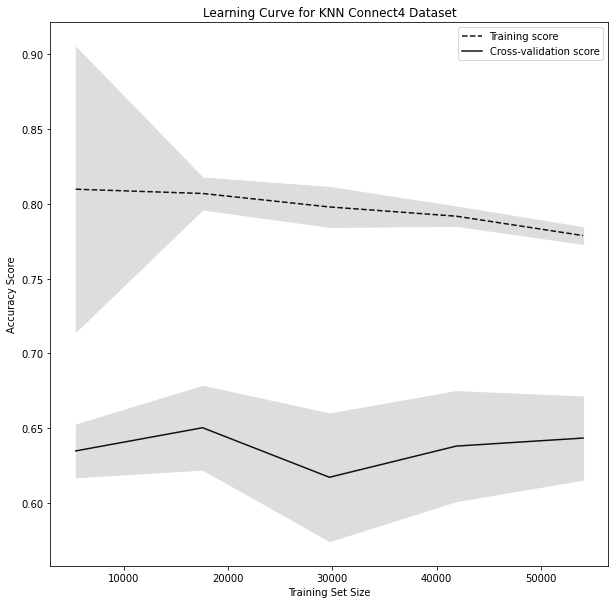

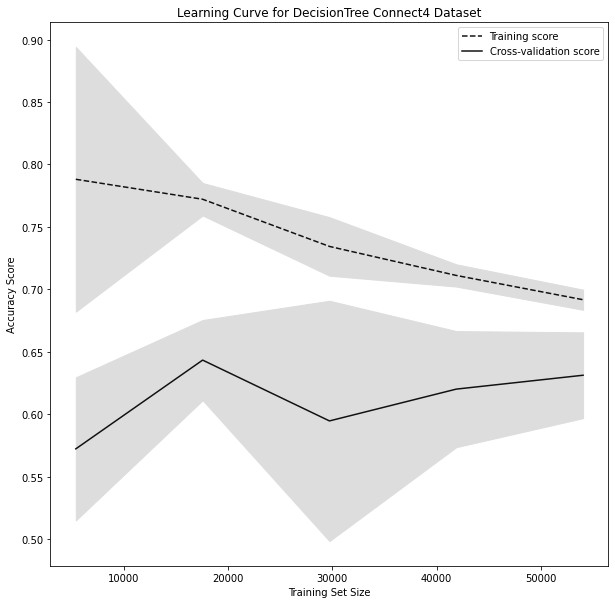

In [33]:
for name in gridcvs:
    train_size, train_score, test_score = learning_curve(gridcvs[name].best_estimator_,
                                                        X, Y,
                                                        cv = 5, n_jobs = 4,
                                                        scoring = 'accuracy')
    plot(train_size, train_score, test_score, name+' Connect4 Dataset')